# Classifying Air Jordan Sneakers
## Author: Sampson Mao

Nike Air Jordans are one of the most popular line of sneakers produced by Nike. The original Air Jordan (AJ) shoe, designed by Peter B. Moore, was made for basketball player Michael Jordan during his sophomore season with the Chicago Bulls. The success of the Air Jordans (now known as the I's) led to the creation of the Air Jordan line of shoes, with 37 (XXXVII) in total as of 2023. This notebook will try to classify the first 21 from their images.

In [1]:
%reload_ext lab_black
%load_ext autoreload
%autoreload 2

In [54]:
import os
import random
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import utils

In [3]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Finding Valid Images

The images appear to be scraped from the web. Upon further inspection, the "corrupted" data were html files. Here, I remove those files while making sure the files that are actually images have the right color mode.

In [4]:
IMAGE_DIR = "C:\\Users\\Sampson\\Desktop\\projects\\jordans_classifier\\images"

In [ ]:
# Move image files up one directory
for upper_dir_path in Path(IMAGE_DIR).iterdir():
    for image_path in upper_dir_path.rglob("*"):
        image_path.rename(upper_dir_path / image_path.name)
    image_path.parent.rmdir()

In [ ]:
for x in os.walk(IMAGE_DIR):
    os.makedirs(x[0].replace("images", "data"), exist_ok=True)
    os.makedirs(x[0].replace("images", "corrupted"), exist_ok=True)

for path, subdirs, files in os.walk(IMAGE_DIR):
    print("Sorting", path)
    for filename in files:
        img_path = os.path.join(path, filename)
        try:
            img = Image.open(img_path)
            save_path = img_path.replace("images", "data")
            if img.format in ["BMP", "GIF", "JPEG"]:
                converted_img = img.convert("RGB")
                converted_img.save(save_path)
            elif img.format == "PNG":
                converted_img = img.convert("RGBA")
                # Some pngs were saved with .jpg. This prevents saving with the same name as a 'corrupted' image.
                converted_img.save(save_path.replace(".jpg", ".png"))
            else:
                img.save(save_path)
        except:
            save_path = img_path.replace("images", "corrupted")
            shutil.copy(img_path, save_path)

Sorting C:\Users\Sampson\Desktop\projects\jordans_classifier\images
Sorting C:\Users\Sampson\Desktop\projects\jordans_classifier\images\1
Sorting C:\Users\Sampson\Desktop\projects\jordans_classifier\images\10
Sorting C:\Users\Sampson\Desktop\projects\jordans_classifier\images\11
Sorting C:\Users\Sampson\Desktop\projects\jordans_classifier\images\12
Sorting C:\Users\Sampson\Desktop\projects\jordans_classifier\images\13
Sorting C:\Users\Sampson\Desktop\projects\jordans_classifier\images\14
Sorting C:\Users\Sampson\Desktop\projects\jordans_classifier\images\15
Sorting C:\Users\Sampson\Desktop\projects\jordans_classifier\images\16
Sorting C:\Users\Sampson\Desktop\projects\jordans_classifier\images\17
Sorting C:\Users\Sampson\Desktop\projects\jordans_classifier\images\18
Sorting C:\Users\Sampson\Desktop\projects\jordans_classifier\images\19
Sorting C:\Users\Sampson\Desktop\projects\jordans_classifier\images\2
Sorting C:\Users\Sampson\Desktop\projects\jordans_classifier\images\20
Sorting C:\

### Exploring the Images

For each AJ release, there are many re-releases of the same shoe. For example, AJ12 Retro 'Taxi' released in 2013 while the AJ12 Retro 'Black/Game Royal' released in September of 2019. Both are re-releases of the original AJ12 from 1996. This dataset contains multiple images for each re-release. However these images are not necessarily from different angles and orientations so some data augmentation may be beneficial.

In [6]:
DATA_DIR = "C:\\Users\\Sampson\\Desktop\\projects\\jordans_classifier\\data"

In [7]:
img_path_list = []
img_path_dict = {str(i + 1): [] for i in range(21)}
for path, subdirs, files in os.walk(DATA_DIR):
    for filename in files:
        # List of all image paths
        img_path = os.path.join(path, filename)
        img_path_list.append(img_path)

        # Paths grouped by shoe
        shoe_number = img_path.split("\\")[-2]
        img_path_dict[shoe_number].append(img_path)

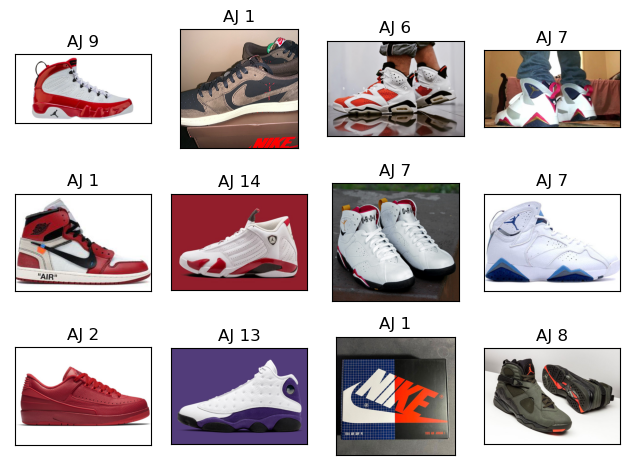

In [8]:
random.seed(10)

utils.show_random_set_of_shoes(img_path_list, 12, col_wrap=4)

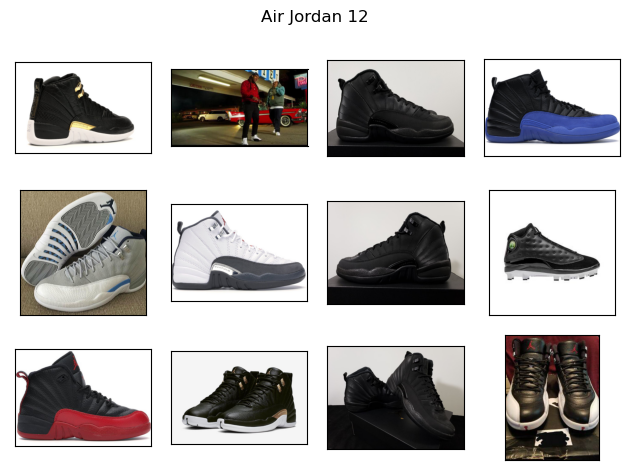

In [9]:
random.seed(10)

utils.show_shoe_series(img_path_dict, 12, 12, col_wrap=4)

### Modeling

There are many stock images in this dataset. In addition, some images are not of shoes (but a shoebox). As mentioned previously, there isn't too much variety for each (re-release) of each shoe, so we augment the data. Additionally, we shrink the images to a smaller size of (128,128) so that the model does not take too long to train.

In [10]:
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2,
)

In [13]:
train_ds = datagen.flow_from_directory(
    DATA_DIR,
    subset="training",
    target_size=(256, 256),
    class_mode="sparse",
    batch_size=16,
)
val_ds = datagen.flow_from_directory(
    DATA_DIR,
    subset="validation",
    target_size=(256, 256),
    class_mode="sparse",
    batch_size=16,
)

Found 7504 images belonging to 21 classes.
Found 1867 images belonging to 21 classes.


In [14]:
inputs = tf.keras.Input(shape=(256, 256, 3))
x = tf.keras.layers.Conv2D(
    filters=16, kernel_size=(5, 5), activation="relu", padding="same"
)(inputs)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)
x = tf.keras.layers.Conv2D(
    filters=32, kernel_size=(5, 5), activation="relu", padding="same"
)(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
output = tf.keras.layers.Dense(21, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=output)

In [15]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 16)      1216      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      12832     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0   

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["sparse_categorical_accuracy"],
)

In [17]:
model.fit(train_ds, validation_data=val_ds, epochs=100)

Epoch 1/100
469/469 [==============================] - 158s 327ms/step - loss: 3.0039 - sparse_categorical_accuracy: 0.0758 - val_loss: 2.8624 - val_sparse_categorical_accuracy: 0.0787
Epoch 2/100
469/469 [==============================] - 148s 316ms/step - loss: 2.8392 - sparse_categorical_accuracy: 0.0846 - val_loss: 2.8339 - val_sparse_categorical_accuracy: 0.0809
Epoch 3/100
469/469 [==============================] - 150s 319ms/step - loss: 2.8317 - sparse_categorical_accuracy: 0.0938 - val_loss: 2.8514 - val_sparse_categorical_accuracy: 0.0798
Epoch 4/100
469/469 [==============================] - 148s 316ms/step - loss: 2.8008 - sparse_categorical_accuracy: 0.1079 - val_loss: 2.8030 - val_sparse_categorical_accuracy: 0.1028
Epoch 5/100
469/469 [==============================] - 148s 316ms/step - loss: 2.7778 - sparse_categorical_accuracy: 0.1119 - val_loss: 2.8339 - val_sparse_categorical_accuracy: 0.0868
Epoch 6/100
469/469 [==============================] - 148s 315ms/step - lo

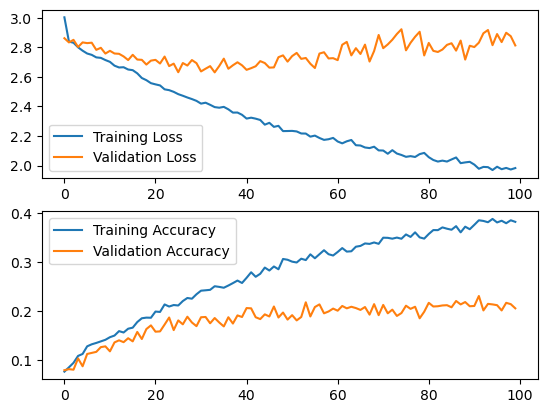

In [18]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(model.history.history["loss"], label="Training Loss")
ax[0].plot(model.history.history["val_loss"], label="Validation Loss")
ax[0].legend()
ax[1].plot(
    model.history.history["sparse_categorical_accuracy"], label="Training Accuracy"
)
ax[1].plot(
    model.history.history["val_sparse_categorical_accuracy"],
    label="Validation Accuracy",
)
ax[1].legend()

Based on the results of the optimization, it looks like we have a classic case of overfitting. The training loss decreases throughout the fitting process, while the validation decreases until around 35 epochs, thens increase. If we think of this in terms of negative log likelihoods, a small NLL (and thus high LL) means that the distribution/model is likely to have produced the data while a large NLL means the opposite. The training accuracy keeps decreasing while the validation accuracy appears to plateau.

The recommended solutions are usually using a simpler model and regularization (dropout, or regularizers in the dense layers).

In [19]:
model.save("./model/")

INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


How would this model do on unseen images? Images of shoes yet to be released was obtained from [here](https://justfreshkicks.com/air-jordan-release-dates-2023/), so they will definitely have not been seen by the model.

In [77]:
TEST_DIR = "C:\\Users\\Sampson\\Desktop\\projects\\jordans_classifier\\test"

In [78]:
test_datagen = ImageDataGenerator(
    rescale=1 / 255.0,
)

In [79]:
test_ds = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(256, 256),
    batch_size=1,
    class_mode="sparse",
)

Found 42 images belonging to 11 classes.


Evaluating the model on this dataset, we get the loss is around 5.5 and the accuracy is around 0.12, which is much worse than the validation values. This is what we expect since we have established that the model overfits.

In [80]:
model.evaluate_generator(test_ds)

c:\Users\Sampson\mambaforge\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[5.474188804626465, 0.1190476194024086]

The following code maps the predicted classes to the actual shoe number, then compares the actual vs the predicted labels

In [81]:
class_index_to_label_dict = {
    index: label for label, index in train_ds.class_indices.items()
}

In [82]:
test_labels = np.vectorize(class_index_to_label_dict.get)(test_ds.classes)

In [83]:
predicted_probabilities = model.predict(test_ds)
predicted_class_indices = predicted_probabilities.argmax(axis=-1)
predicted_labels = np.vectorize(class_index_to_label_dict.get)(predicted_class_indices)

42/42 [==============================] - 0s 6ms/step


As we can see, there is still a lot to be done to tweak the model in order for it to make better predictions. As mentioned before, some possible remedies are a simpler model and regularization. More data that are varied can help too for generalization. Additionally, using callbacks to find an optimal learning rate might be useful, since we saw that the validation loss did form a dip, so at one point the optimization trajectory was in the right direction but later went off its tracks. Lastly, the parameters of each layer can be tweaked further to find an optimum value.

In [84]:
predictions_df = pd.DataFrame()
predictions_df.assign(actual=test_labels, predicted=predicted_labels)

,actual,predicted
0,1,14
1,1,11
2,1,6
3,1,1
4,1,1
5,1,8
6,1,3
7,1,1
8,1,13
9,1,6
